# Using `bbo` for auto-tuning of Machine Learning models

In this example, we will use `bbo` as a stand-alone black-box optimization library to find the optimum hyper-parameters (a *Support Vector Machine* and a *RandomForestClassifier*) for two Machine Learning models, on the `breast_cancer` dataset.

## Loading the dataset
The [`breast_cancer` dataset](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset) is a classic and very easy binary classification dataset. We will use it as an example for tuning the models. After loading the data, we will use the `train_test_split` function to divide the dataset into a train dataset (that we will train the model on) and a test dataset (where we will evaluate the model on to get its accuracy on unseen data). As `bbo` is a *minimizer*, we will use the opposite value of the accuracy as a training target.

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(data["data"], data["target"], test_size=0.33, random_state=42)

## Design black-box class
To use `bbo`, we need to design two classes that act as black-box that can be tuned: they have a `compute` method that takes as input a parametrization, trains the model using this parametrization on the train data, evaluates the model on the test data and return the opposite of the accuracy.

We will tune two sklearn models:
- [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC): we will look for the optimum value of:
    * C
    * kernel
    * degree
    * gamma
    * coef0
    * shrinking
    * probability
    * tol
 
- [Random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier): we will look for the optimum of:
    * n_estimators
    * criterion
    * max_depth
    * min_samples_split
    * min_weight_fraction_leaf
    * max_features
    
 For each model, we will define the class with the `compute` method and the corresponding `parametric_grid` (*i.e* the values that can be tested by the optimizer).

In [2]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [3]:
class OptimizableSVM:
    """
    Optimizable class to find the optimal parametrization of a SVM model.
    """
    def compute(self, parameters):
        """
        Outputs the cross validation score for the model.
        """
        parameters_dict = {"C": float(parameters[0]), "kernel": str(parameters[1]), "degree": int(parameters[2]), "gamma": str(parameters[3]), "coef0": float(parameters[4]), "shrinking": bool(parameters[5]), "probability": bool(parameters[6]), "tol": float(parameters[7])}
        svc = SVC(**parameters_dict)
        svc.fit(X_train, y_train)
        return -svc.score(X_test, y_test)
    
# Define parametric grid
c = np.arange(1, 100, 1)
kernel = np.array(["linear", "poly", "rbf", "sigmoid"])
degree = np.arange(1, 4, 1)
gamma = np.array(['scale', 'auto'])
coef = np.arange(0, 1, 0.01)
shrinking = np.array([True, False])
probability = np.array([True, False])
tol = np.arange(0.01, 0.1, 0.01)

svm_parametric_grid = np.array([c, kernel, degree, gamma, coef, shrinking, probability, tol], dtype=object)

In [4]:
class OptimizableRandomForest:
    """
    Model that will act as a black-box.
    """
    def compute(self, parameters):
        parameters_dict = {"n_estimators": int(parameters[0]), "criterion": str(parameters[1]), "max_depth": float(parameters[2]), "min_samples_split": int(parameters[3]), "min_weight_fraction_leaf":float(parameters[4]), "max_features": str(parameters[5])}
        random_forest = RandomForestClassifier(**parameters_dict)
        random_forest.fit(X_train, y_train)
        return -random_forest.score(X_test, y_test)

n_estimators = np.arange(50, 200, 20)
criterion = np.array(["gini", "entropy"])
max_depth = np.arange(5, 10, 1)
min_samples_split = np.arange(2, 10, 1)
min_weight_fraction_leaf = np.arange(0, 0.4, 0.1)
max_features = np.array(["auto", "sqrt", "log2"])

rf_parametric_grid = np.array([n_estimators, criterion, max_depth, min_samples_split, min_weight_fraction_leaf, max_features], dtype=object)

## Setup optimizer
We then need to set-up the optimizer. As **they are currently the only heuristic that support qualitative variable**, we will use genetic algorithms, with single point crossovers and a tournament pick. The mutation rate is set to 0.3. We will have 5 initial data points, for a maximum of 20 iterations.

In [5]:
from bbo.optimizer import BBOptimizer
from bbo.heuristics.genetic_algorithm.mutations import mutate_chromosome_to_neighbor
from bbo.heuristics.genetic_algorithm.selections import tournament_pick 
from bbo.heuristics.genetic_algorithm.crossover import single_point_crossover

In [6]:
svm_model = OptimizableSVM()
svm_bb = BBOptimizer(black_box = svm_model, # the black-box to optimize
                     parameter_space = svm_parametric_grid, # the grid on which to perform the optimization
                     initial_sample_size=10,# the initial size of the sample
                     heuristic="genetic_algorithm", # the name of the heuristics to use
                     max_iteration=20, # the maximum number of iterations
                     time_out=200, # in seconds, the maximum elapsed time
                     # the following arguments are specific to genetic algorithms:
                     mutation_method= mutate_chromosome_to_neighbor, # the mutation function
                     mutation_rate=0.3,#the mutation rate
                     crossover_method=single_point_crossover, # the crossover function
                     selection_method=tournament_pick # the selection function
                     ) 

In [7]:
svm_bb.optimize()

2020-11-07 20:19:31.187 | DEBUG    | bbo.optimizer:_initialize:487 - Initializing parameter space
2020-11-07 20:19:31.200 | DEBUG    | bbo.optimizer:_initialize:488 - Parameter space given by user: [array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
 array(['linear', 'poly', 'rbf', 'sigmoid'], dtype='<U7') array([1, 2, 3])
 array(['scale', 'auto'], dtype='<U5')
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.3

2020-11-07 20:20:30.582 | DEBUG    | bbo.optimizer:_optimization_step:473 - Evaluating performance of parametrization ['90' 'poly' '2' 'scale' '0.43' 'True' 'False' '0.02']
2020-11-07 20:20:30.633 | DEBUG    | bbo.optimizer:_optimization_step:476 - Corresponding performance: -0.9893617021276596
2020-11-07 20:20:30.640 | DEBUG    | bbo.optimizer:_optimization_step:473 - Evaluating performance of parametrization ['89' 'linear' '2' 'scale' '0.42' 'True' 'True' '0.08']
2020-11-07 20:20:47.162 | DEBUG    | bbo.optimizer:_optimization_step:476 - Corresponding performance: -0.9468085106382979
2020-11-07 20:20:47.166 | DEBUG    | bbo.optimizer:_optimization_step:473 - Evaluating performance of parametrization ['90' 'linear' '1' 'scale' '0.42' 'True' 'True' '0.08']
2020-11-07 20:21:19.290 | DEBUG    | bbo.optimizer:_optimization_step:476 - Corresponding performance: -0.9468085106382979
2020-11-07 20:21:19.305 | DEBUG    | bbo.optimizer:_optimization_step:473 - Evaluating performance of parametr

array(['90', 'poly', '2', 'scale', '0.43', 'True', 'False', '0.02'],
      dtype=object)

In [8]:
rf_model = OptimizableRandomForest()
rf_bb = BBOptimizer(black_box = rf_model, # the black-box to optimize
                     parameter_space = rf_parametric_grid, # the grid on which to perform the optimization
                     initial_sample_size=10,# the initial size of the sample
                     heuristic="genetic_algorithm", # the name of the heuristics to use
                     max_iteration=20, # the maximum number of iterations
                     time_out=200, # in seconds, the maximum elapsed time
                     # the following arguments are specific to genetic algorithms:
                     mutation_method= mutate_chromosome_to_neighbor, # the mutation function
                     mutation_rate=0.3,#the mutation rate
                     crossover_method=single_point_crossover, # the crossover function
                     selection_method=tournament_pick # the selection function
                     ) 

In [9]:
rf_bb.optimize()

2020-11-07 20:21:39.466 | DEBUG    | bbo.optimizer:_initialize:487 - Initializing parameter space
2020-11-07 20:21:39.475 | DEBUG    | bbo.optimizer:_initialize:488 - Parameter space given by user: [array([ 50,  70,  90, 110, 130, 150, 170, 190])
 array(['gini', 'entropy'], dtype='<U7') array([5, 6, 7, 8, 9])
 array([2, 3, 4, 5, 6, 7, 8, 9]) array([0. , 0.1, 0.2, 0.3])
 array(['auto', 'sqrt', 'log2'], dtype='<U4')]
2020-11-07 20:21:39.478 | DEBUG    | bbo.initial_parametrizations:hybrid_lhs_uniform_sampling:104 - Selected number of initial parameters: 10
2020-11-07 20:21:39.483 | DEBUG    | bbo.optimizer:_initialize:494 - Selected initial parameter space: {initial_parameters}
2020-11-07 20:21:39.485 | DEBUG    | bbo.optimizer:_optimization_step:473 - Evaluating performance of parametrization [110 'entropy' 5 5 0.1 'sqrt']
2020-11-07 20:21:39.829 | DEBUG    | bbo.optimizer:_optimization_step:476 - Corresponding performance: -0.9574468085106383
2020-11-07 20:21:39.830 | DEBUG    | bbo.op

2020-11-07 20:21:49.904 | DEBUG    | bbo.optimizer:_optimization_step:473 - Evaluating performance of parametrization ['70' 'entropy' '5' '7' '0.0' 'log2']
2020-11-07 20:21:50.127 | DEBUG    | bbo.optimizer:_optimization_step:476 - Corresponding performance: -0.9680851063829787
2020-11-07 20:21:50.129 | DEBUG    | bbo.optimizer:_optimization_step:473 - Evaluating performance of parametrization ['130' 'gini' '7' '7' '0.0' 'log2']
2020-11-07 20:21:50.433 | DEBUG    | bbo.optimizer:_optimization_step:476 - Corresponding performance: -0.9521276595744681
2020-11-07 20:21:50.436 | DEBUG    | bbo.optimizer:_optimization_step:473 - Evaluating performance of parametrization ['110' 'entropy' '5' '4' '0.0' 'sqrt']
2020-11-07 20:21:50.985 | DEBUG    | bbo.optimizer:_optimization_step:476 - Corresponding performance: -0.973404255319149


array(['110', 'entropy', '5', '4', '0.0', 'sqrt'], dtype=object)

## Read results

The results of the optimization can be read using the `summary` method on each object. The fitness (*i.e.* the accuracy as a function of the iteration step) can also be plotted to look at the convergence trajectory.

In [12]:
from matplotlib import pyplot as plt

In [10]:
svm_bb.summarize()

------ Optimization loop summary ------
Number of iterations: 30
Elapsed time: 128.2299826145172
Best parameters: ['90' 'poly' '2' 'scale' '0.43' 'True' 'False' '0.02']
Best fitness value: -0.9893617021276596
Some statistics are yet unavailable for mixedtypes variables.
--- Heuristic specific summary ---
Number of mutations: 12
Family tree:
['89' 'rbf' '2' 'scale' '0.2' 'True' 'True' '0.08'] + ['35' 'rbf' '2' 'scale' '0.43' 'False' 'False' '0.02']
|_> ['89' 'rbf' '2' 'scale' '0.43' 'False' 'False' '0.02']
['89' 'rbf' '2' 'scale' '0.43' 'False' 'False' '0.02'] + ['89' 'rbf' '2' 'scale' '0.2' 'True' 'True' '0.08']
|_> ['90' 'poly' '2' 'scale' '0.43' 'True' 'True' '0.08']
['90' 'poly' '2' 'scale' '0.43' 'True' 'True' '0.08'] + ['89' 'rbf' '2' 'scale' '0.43' 'False' 'False' '0.02']
|_> ['90' 'poly' '2' 'scale' '0.43' 'False' 'False' '0.02']
['90' 'poly' '2' 'scale' '0.43' 'False' 'False' '0.02'] + ['90' 'poly' '2' 'scale' '0.43' 'True' 'True' '0.08']
|_> ['90' 'poly' '2' 'scale' '0.43' 'Fa

Text(0.5, 1.0, 'Accuracy as a function of the number of iterations for SVM model')

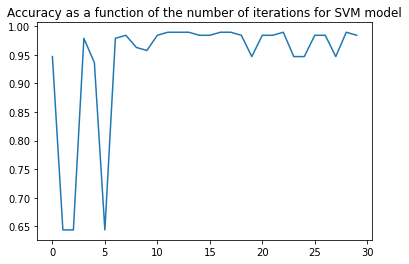

In [17]:
plt.plot(-svm_bb.history["fitness"])
plt.title("Accuracy as a function of the number of iterations for SVM model")

In [11]:
rf_bb.summarize()

------ Optimization loop summary ------
Number of iterations: 30
Elapsed time: 11.522201299667358
Best parameters: ['110' 'entropy' '5' '4' '0.0' 'sqrt']
Best fitness value: -0.973404255319149
Some statistics are yet unavailable for mixedtypes variables.
--- Heuristic specific summary ---
Number of mutations: 9
Family tree:
['130' 'gini' '7' '9' '0.1' 'auto'] + [110 'entropy' 5 5 0.1 'sqrt']
|_> ['130' 'gini' '7' 5 0.1 'sqrt']
['130' 'gini' '5' '3' '0.0' 'log2'] + ['130' 'gini' '7' 5 0.1 'sqrt']
|_> ['130' 'gini' '5' 5 0.1 'sqrt']
['190' 'gini' '7' '6' '0.0' 'log2'] + ['130' 'gini' '7' 5 0.1 'sqrt']
|_> ['190' 'gini' '7' 5 0.1 'sqrt']
[110 'entropy' 5 5 0.1 'sqrt'] + ['130' 'gini' '7' '9' '0.1' 'auto']
|_> [110 'entropy' '7' '9' '0.1' 'auto']
['130' 'gini' '7' '9' '0.1' 'auto'] + ['190' 'gini' '7' 5 0.1 'sqrt']
|_> ['130' 'gini' '7' '9' 0.1 'sqrt']
['130' 'gini' '5' '3' '0.0' 'log2'] + ['190' 'gini' '7' '6' '0.0' 'log2']
|_> ['130' 'gini' '7' '6' '0.0' 'log2']
[110 'entropy' 5 5 0.1 's

Text(0.5, 1.0, 'Accuracy as a function of the number of iterations for Random Forest model')

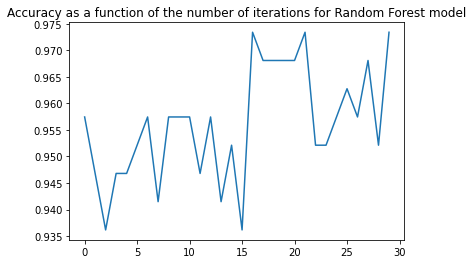

In [19]:
plt.plot(-rf_bb.history["fitness"])
plt.title("Accuracy as a function of the number of iterations for Random Forest model")

In [23]:
import numpy as np


class FakeBlackBox:
    def __init__(self):
        print("I'm the Ackley function ! Good luck finding my optimum !")
        
    def compute(self, array_2d):
        return -20 * np.exp(-0.2 * np.sqrt(0.5 * (array_2d[0]**2 + array_2d[1]**2))) - np.exp(0.5 * (np.cos(2 * np.pi * array_2d[0]) + np.cos(2 * np.pi * array_2d[1]))) + np.exp(1) + 20

# create the fake_black_box object
fake_black_box = FakeBlackBox()
# choose the optimization grid
parametric_grid = np.array([np.arange(-10, 10, 1), np.arange(-5, 5, 1)]).T

I'm the Ackley function ! Good luck finding my optimum !


<ipython-input-23-bb56808ee997>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  parametric_grid = np.array([np.arange(-10, 10, 1), np.arange(-5, 5, 1)]).T


In [26]:
from bbo.optimizer import BBOptimizer
import numpy
from bbo.heuristics.surrogate_models.next_parameter_strategies import expected_improvement
from sklearn.gaussian_process import GaussianProcessRegressor


bb_obj = BBOptimizer(
    black_box=fake_black_box,
    heuristic="surrogate_model",
    max_iteration=20,
    initial_sample_size=2,
    parameter_space=parametric_grid,
    next_parameter_strategy=expected_improvement,
    regression_model=GaussianProcessRegressor,
    resampling_policy="dynamic_resampling",
    percentage=0.1,
)